In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import copy # 조기종료를 위해 깊은 복사를 사용을 위해
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# PyTorch 출력 형식 조정
torch.set_printoptions(precision=8, threshold=10000, edgeitems=3)

In [2]:
# num_workers 병렬처리를 위해 윈도우에서 사용
import torch.multiprocessing as mp
import os

# 환경 변수 설정
os.environ['OMP_NUM_THREADS'] = '1'
mp.set_start_method('spawn', force=True)

In [3]:
train_data = "C:/Users/admin/Downloads/wiset_single_sensor_model_train_data_3.xlsx"
test_data = "C:/Users/admin/Downloads/test_data_20240407.xlsx"

# 엑셀데이터 데이터프레임으로 읽어오기
trains_df = pd.read_excel(train_data)
tests_df = pd.read_excel(test_data)

# 데이터 프레임의 크기 확인
train_rows = trains_df.shape[0]
test_rows = tests_df.shape[0]

# 불러온 데이터의 행 수 출력
print(f'Trains 데이터 프레임의 행 수: {train_rows}')
print(f'Tests 데이터 프레임의 행 수: {test_rows}')

# 조건 확인
if train_rows == 256421 and test_rows == 8261:
    print("데이터가 올바르게 로드되었습니다.")
else:
    print("데이터 로딩에 문제가 있습니다.")
    
# train 데이터프레임의 모든 object 타입 열을 숫자로 변환
for col in trains_df.select_dtypes(include=['object']).columns:
    trains_df[col] = pd.to_numeric(trains_df[col], errors='coerce')
    
# test 데이터프레임의 모든 object 타입 열을 숫자로 변환
for col in tests_df.select_dtypes(include=['object']).columns:
    tests_df[col] = pd.to_numeric(tests_df[col], errors='coerce')

Trains 데이터 프레임의 행 수: 256421
Tests 데이터 프레임의 행 수: 8261
데이터가 올바르게 로드되었습니다.


In [4]:
# 불필요한 열 제거
trains = trains_df.drop(columns=['Unnamed: 0', 'datetime', 'point'])
tests = tests_df.drop(columns=['datetime', 'point'])

In [5]:
# 거리 특성 추가
trains['distance_from_0_0'] = np.sqrt((trains['x'] - 0)**2 + (trains['y'] - 0)**2)
tests['distance_from_0_0'] = np.sqrt((tests['x'] - 0)**2 + (tests['y'] - 0)**2)

In [6]:
# input과 target 데이터 나누기 - train
train_input = trains.drop(columns=['illum'], axis=1).to_numpy()
train_target = trains['illum'].to_numpy()

# test
test_input = tests.drop(columns=['illum'], axis=1).to_numpy()
test_target = tests['illum'].to_numpy()

# train 데이터를 훈련 데이터와 검증 데이터로 분할
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

# Numpy 배열의 데이터 타입 변환
train_input = train_input.astype(np.float32)
train_target = train_target.astype(np.float32)
val_input = val_input.astype(np.float32)
val_target = val_target.astype(np.float32)
test_input = test_input.astype(np.float32)
test_target = test_target.astype(np.float32)

# 파이토치 모델 쓰려면 df or numpy -> Pytorch 텐서로 변환해야 됨
train_input = torch.tensor(train_input, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_input = torch.tensor(val_input, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
test_input = torch.tensor(test_input, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

# 각 텐서에서 0 값의 개수 확인
num_zeros_train = torch.sum(train_target == 0).item()
num_zeros_val = torch.sum(val_target == 0).item()
num_zeros_test = torch.sum(test_target == 0).item()

print(f"Number of zeros in train_target: {num_zeros_train}")
print(f"Number of zeros in val_target: {num_zeros_val}")
print(f"Number of zeros in test_target: {num_zeros_test}")

# 각 텐서의 dtype 확인
print(f"train_target dtype: {train_target.dtype}")
print(f"val_target dtype: {val_target.dtype}")
print(f"test_target dtype: {test_target.dtype}")

# 각 텐서의 shape 확인
print(f"train_target shape: {train_target.shape}")
print(f"val_target shape: {val_target.shape}")
print(f"test_target shape: {test_target.shape}")

Number of zeros in train_target: 2
Number of zeros in val_target: 0
Number of zeros in test_target: 0
train_target dtype: torch.float32
val_target dtype: torch.float32
test_target dtype: torch.float32
train_target shape: torch.Size([205136])
val_target shape: torch.Size([51285])
test_target shape: torch.Size([8261])


In [7]:
# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_input, train_target = train_input.to(device), train_target.to(device)
val_input, val_target = val_input.to(device), val_target.to(device)
test_input, test_target = test_input.to(device), test_target.to(device)

print(train_target)

tensor([494.54037476, 326.48706055,  10.41145897,  ...,  55.51983643,
         76.86361694, 300.33477783], device='cuda:0')


In [8]:
def worker_init_fn(worker_id):
    # 각 worker가 초기화될 때 설정할 내용 (필요시 수정)
    worker_info = torch.utils.data.get_worker_info()
    if worker_info is not None:
        np.random.seed(worker_info.seed % 2**32)
    print(f"Worker {worker_id} initialized.")

In [9]:
# 데이터셋과 데이터로더 생성(미니배치)
# epoch 너무 느릴 때 데이터를 배치로 나눠 처리하게 하기

# 배치 크기 늘리면 에포크 학습시간 단축됨
# 너무 크면 메모리 사용량 증가시킴
train_dataset = TensorDataset(train_input, train_target)
val_dataset = TensorDataset(val_input, val_target)

print(train_dataset[0])
print(train_target)

num_workers=1

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=True, worker_init_fn=worker_init_fn)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=True, worker_init_fn=worker_init_fn)


(tensor([  58.11999893,  150.64999390,  884.20678711, -120.00000000,
          60.00000000,  134.16407776], device='cuda:0'), tensor(494.54037476, device='cuda:0'))
tensor([494.54037476, 326.48706055,  10.41145897,  ...,  55.51983643,
         76.86361694, 300.33477783], device='cuda:0')


In [10]:
# DataLoader를 사용하여 예시 배치 데이터를 가져오기

try:
    for i, (batch_inputs1, batch_targets1) in enumerate(train_loader):
        print(f"Batch {i} targets before moving to device: {batch_targets1[:10]}")
        batch_inputs1, batch_targets1 = batch_inputs1.to('cuda' if torch.cuda.is_available() else 'cpu'), batch_targets1.to('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Batch {i} targets after moving to device: {batch_targets1[:10]}")
        # 모델 예측 (모델 정의가 필요합니다)
        # model.eval()
        # with torch.no_grad():
        #     outputs = model(batch_inputs1)
        # print(f'Outputs shape: {outputs.shape}')
        print(f'Batch targets shape: {batch_targets1.shape}')
        print(f"Batch {i} targets after model eval: {batch_targets1[:10]}")
        break
except Exception as e:
    print(f"An error occurred: {e}")

print(f"Train target after DataLoader with num_workers={num_workers}: {train_target[:10]}")

Batch 0 targets before moving to device: tensor([213.06816101, 626.27453613, 208.38374329, 371.50259399,  69.04563904,
        187.95149231,  24.31603432,   9.37261295], device='cuda:0')
Batch 0 targets after moving to device: tensor([213.06816101, 626.27453613, 208.38374329, 371.50259399,  69.04563904,
        187.95149231,  24.31603432,   9.37261295], device='cuda:0')
Batch targets shape: torch.Size([8])
Batch 0 targets after model eval: tensor([213.06816101, 626.27453613, 208.38374329, 371.50259399,  69.04563904,
        187.95149231,  24.31603432,   9.37261295], device='cuda:0')
Train target after DataLoader with num_workers=1: tensor([494.54037476, 326.48706055,  10.41145897,  27.11094475, 272.62899780,
        817.96411133, 339.71627808, 306.31503296, 354.50357056, 277.76501465],
       device='cuda:0')


In [11]:
# dnn 모델
class dnn(nn.Module):
    # 생성자에서 모델의 구조 정의
    def __init__(self):
        # nn.Module 클래스를 상속받아 super로 nn.Module의 초기화 메소드 호출
        super(dnn, self).__init__()
        # 입력층(은닉층1) 입력 6개 - elevation, azimuth, new_illum_11, x, y, distance
        self.fc1 = nn.Linear(train_input.shape[1], 256)
        
        # droopout 과대적합 방지 - 학습 중에만 활성화(평가, 예측 시 비활성화)
        # 은닉층 뒤에 추가됨
        #self.dropout1 = nn.Dropout(0.5) 
        
        # 64개의 출력 뉴런에 대해 배치 정규화
        # 각 층에 입력되는 데이터의 분포를 정규화하여 학습 안정화, 속도 높임
        # 각 층 뒤, 활성함수 이전에 사용
        #self.bn1 = nn.BatchNorm1d(64)
    
        # 은닉층과 배치 정규화
        self.fc2 = nn.Linear(256, 512)
        #self.bn2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(512, 256)
        #self.bn3 = nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(256, 128)
        #self.bn4 = nn.BatchNorm1d(32)
        
        # 출력층 출력 1개
        self.fc5 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        
        # forward: 각 계층 연결방식, 활성화 함수, 추가 처리 적용
        # fc1 선형계층 -> bn1 배치활성화 -> relu로 비선형성 적용
    def forward(self, x):
        # 활성화 함수 relu 사용 (비교되는거 - 시그모이드)
        x = torch.relu(self.fc1(x))
        #x = self.dropout(x)
            
        x = torch.relu(self.fc2(x))
        #x = self.dropout(x)
            
        x = torch.relu(self.fc3(x))
        #x = self.dropout(x)

        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.fc5(x) # 출력층
            
        return x

In [12]:
train_target

tensor([494.54037476, 326.48706055,  10.41145897,  ...,  55.51983643,
         76.86361694, 300.33477783], device='cuda:0')

In [13]:
# 모델 생성
input_size = train_input.shape[1]
print(input_size)
print(train_input)
model = dnn()
model.to(device)

6
tensor([[  58.11999893,  150.64999390,  884.20678711, -120.00000000,
           60.00000000,  134.16407776],
        [  48.56999969,  233.60000610,  774.67169189,  120.00000000,
          120.00000000,  169.70562744],
        [   1.99000001,   65.29000092,   27.32855797, -120.00000000,
           60.00000000,  134.16407776],
        ...,
        [  10.46000004,   83.66000366,  137.01922607, -120.00000000,
          120.00000000,  169.70562744],
        [  10.18999958,  271.30999756,  151.51042175,    0.00000000,
          120.00000000,  120.00000000],
        [  29.56999969,  254.50000000,  511.94494629, -120.00000000,
          120.00000000,  169.70562744]], device='cuda:0')


dnn(
  (fc1): Linear(in_features=6, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [14]:
train_target

tensor([494.54037476, 326.48706055,  10.41145897,  ...,  55.51983643,
         76.86361694, 300.33477783], device='cuda:0')

In [15]:
# 가중치 초기화 함수 적용
# 각 리니어 레이어의 가중치를 He 방식으로 초기화
# 균형 잡힌 학습을 도와줌
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

model.apply(initialize_weights)

dnn(
  (fc1): Linear(in_features=6, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
train_target

tensor([494.54037476, 326.48706055,  10.41145897,  ...,  55.51983643,
         76.86361694, 300.33477783], device='cuda:0')

In [17]:
# 손실함수, 옵티마이저
criterion = nn.L1Loss() # MAE 손실함수
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

In [18]:
train_target

tensor([494.54037476, 326.48706055,  10.41145897,  ...,  55.51983643,
         76.86361694, 300.33477783], device='cuda:0')

In [19]:

# DataLoader를 사용하여 예시 배치 데이터를 가져오기
for i, (batch_inputs1, batch_targets1) in enumerate(train_loader):
    print(batch_targets1[:10])
    
    # 배치 데이터를 GPU로 이동
    batch_inputs, batch_targets = batch_inputs1.to(device), batch_targets1.to(device)
    
    # 배치 데이터 확인
    print(f"Batch {i} targets before model eval: {batch_targets[:10]} {batch_targets1[:10]}")
    
    # 모델 예측
    model.eval()
    with torch.no_grad():
        outputs = model(batch_inputs)
    
    # 출력 크기와 타깃 크기 확인
    print(f'Outputs shape: {outputs.shape}')
    print(f'Batch targets shape: {batch_targets.shape}')
    
    # 배치 데이터 다시 확인
    print(f"Batch {i} targets after model eval: {batch_targets[:10]}")
    
    # 한번만 확인하고 루프 종료
    break


tensor([130.29284668,  51.19895172, 185.49316406, 198.50073242, 244.21151733,
         70.00260162, 345.62939453, 105.12885284], device='cuda:0')
Batch 0 targets before model eval: tensor([130.29284668,  51.19895172, 185.49316406, 198.50073242, 244.21151733,
         70.00260162, 345.62939453, 105.12885284], device='cuda:0') tensor([130.29284668,  51.19895172, 185.49316406, 198.50073242, 244.21151733,
         70.00260162, 345.62939453, 105.12885284], device='cuda:0')
Outputs shape: torch.Size([8, 1])
Batch targets shape: torch.Size([8])
Batch 0 targets after model eval: tensor([130.29284668,  51.19895172, 185.49316406, 198.50073242, 244.21151733,
         70.00260162, 345.62939453, 105.12885284], device='cuda:0')


In [20]:
'''
# 예시 배치 데이터
batch_inputs, batch_targets = next(iter(train_loader))
batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

# 모델 예측
model.eval()
with torch.no_grad():
    outputs = model(batch_inputs)

# 출력 크기와 타깃 크기 확인
print(f'Outputs shape: {outputs.shape}')
print(f'Batch targets shape: {batch_targets.shape}')
'''

"\n# 예시 배치 데이터\nbatch_inputs, batch_targets = next(iter(train_loader))\nbatch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)\n\n# 모델 예측\nmodel.eval()\nwith torch.no_grad():\n    outputs = model(batch_inputs)\n\n# 출력 크기와 타깃 크기 확인\nprint(f'Outputs shape: {outputs.shape}')\nprint(f'Batch targets shape: {batch_targets.shape}')\n"

In [21]:
train_target

tensor([494.54037476, 326.48706055,  10.41145897,  ...,  55.51983643,
         76.86361694, 300.33477783], device='cuda:0')

In [22]:
# 학습률 감소 스케줄러
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

In [23]:
# 조기 종료 설정
patience = 30  # 성능 향상이 없을 때 기다릴 에포크 수
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

In [24]:
train_target

tensor([494.54037476, 326.48706055,  10.41145897,  ...,  55.51983643,
         76.86361694, 300.33477783], device='cuda:0')

In [27]:
# 손실 값을 저장할 리스트 초기화
train_losses = []
val_losses = []

In [28]:
train_target

tensor([494.54037476, 326.48706055,  10.41145897,  ...,  55.51983643,
         76.86361694, 300.33477783], device='cuda:0')

In [29]:
# train_target과 test_target을 하나의 텐서로 합치기
all_targets = torch.cat((train_target, val_target))
all_targets = torch.cat((all_targets, test_target))

# 합쳐진 텐서를 GPU로 이동
all_targets = all_targets.to(device)

# 텐서가 제대로 합쳐졌는지 확인
print(f"all_targets[:10]: {all_targets[:10]}")

# 합쳐진 텐서에서 0 값의 개수 확인
num_zeros_all = torch.sum(all_targets == 0).item()
print(f"Number of zeros in all_targets: {num_zeros_all}")

# 타겟 값의 평균 계산
target_mean = torch.mean(all_targets).item()
print(f"Target Mean: {target_mean}")

# 허용 가능한 상대적 오차 설정
acceptable_relative_error = 0.05  # 5%

# 최적의 손실 값 범위 계산
optimal_loss_upper_bound = target_mean * acceptable_relative_error
print(f"Optimal Loss Upper Bound: {optimal_loss_upper_bound}")


all_targets[:10]: tensor([494.54037476, 326.48706055,  10.41145897,  27.11094475, 272.62899780,
        817.96411133, 339.71627808, 306.31503296, 354.50357056, 277.76501465],
       device='cuda:0')
Number of zeros in all_targets: 2
Target Mean: 237.41278076171875
Optimal Loss Upper Bound: 11.870639038085939


In [30]:
train_target

tensor([494.54037476, 326.48706055,  10.41145897,  ...,  55.51983643,
         76.86361694, 300.33477783], device='cuda:0')

In [31]:
all_targets

tensor([494.54037476, 326.48706055,  10.41145897,  ...,   5.00972605,
          4.54747105,   4.12547684], device='cuda:0')

In [32]:
# 모델 학습
epochs = 1000
for epoch in range(epochs):
    model.train()
    for batch_inputs, batch_targets in train_loader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)  # 배치 데이터를 GPU로 이동
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets.unsqueeze(1))  # MAE 손실 계산
        loss.backward()
        optimizer.step()
    
    # 검증 손실 계산
    model.eval()
    val_loss_sum = 0.0
    val_batches = 0
    with torch.no_grad():
        for val_batch_inputs, val_batch_targets in val_loader:
            val_batch_inputs, val_batch_targets = val_batch_inputs.to(device), val_batch_targets.to(device)
            val_outputs = model(val_batch_inputs)
            val_loss = criterion(val_outputs, val_batch_targets.unsqueeze(1))
            val_loss_sum += val_loss.item()
            val_batches += 1
    val_loss_avg = val_loss_sum / val_batches

    # 손실 값 저장
    train_losses.append(loss.item())
    val_losses.append(val_loss_avg)
    
    if val_loss_avg < best_loss:
        best_loss = val_loss_avg
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

    scheduler.step(val_loss_avg)

    # 과대적합: 훈련 손실 < 검증 손실 - 드롭아웃 비율 증가, 층 적게, 규제 크게, 
    # 과소적합: 훈련 손실, 검증 손실 모두 높고 반대
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {val_loss_avg:.4f}')


Epoch [1/1000], Loss: 13.2269, Test Loss: 16.7721
Epoch [11/1000], Loss: 8.6471, Test Loss: 12.8599
Epoch [21/1000], Loss: 24.5007, Test Loss: 11.8418
Epoch [31/1000], Loss: 13.1919, Test Loss: 11.8071
Epoch [41/1000], Loss: 13.5457, Test Loss: 11.0779
Epoch [51/1000], Loss: 14.9345, Test Loss: 10.8803
Epoch [61/1000], Loss: 9.8016, Test Loss: 10.5301
Epoch [71/1000], Loss: 7.8288, Test Loss: 10.2526
Epoch [81/1000], Loss: 20.7864, Test Loss: 11.0359
Epoch [91/1000], Loss: 17.8735, Test Loss: 10.2077
Epoch [101/1000], Loss: 22.0380, Test Loss: 10.4321
Epoch [111/1000], Loss: 24.7571, Test Loss: 10.1001
Epoch [121/1000], Loss: 32.7499, Test Loss: 9.8410
Epoch [131/1000], Loss: 12.7679, Test Loss: 9.8484
Epoch [141/1000], Loss: 15.7471, Test Loss: 9.8374
Epoch [151/1000], Loss: 13.2855, Test Loss: 10.0811
Epoch [161/1000], Loss: 12.6880, Test Loss: 10.0483
Early stopping at epoch 171


In [33]:
# 가장 성능이 좋은 모델 가중치 로드
model.load_state_dict(best_model_wts)

<All keys matched successfully>

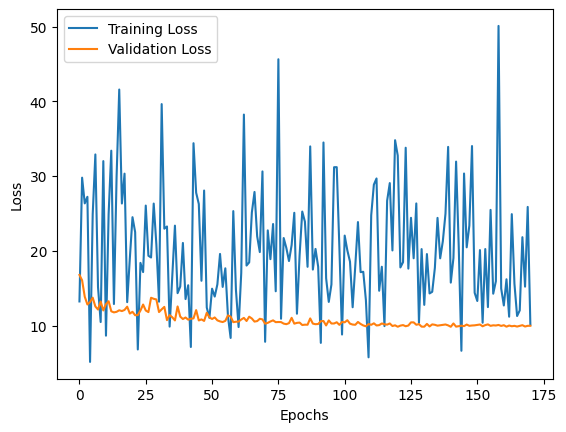

In [34]:
# 손실 값 그래프 그리기
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# 학습된 모델을 평가 모드로 전환 (추론을 위해)
model.eval()

dnn(
  (fc1): Linear(in_features=6, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [36]:
# 테스트 데이터에 대한 예측 및 MAE 계산
with torch.no_grad():
    test_outputs = model(test_input)
    test_loss = criterion(test_outputs, test_target.unsqueeze(1))
    predictions = model(test_input.to(device)).cpu().numpy()

    print(f'Test MAE: {test_loss.item():.4f}')

Test MAE: 6.4306


In [69]:
# 테스트 데이터에 예측값 추가
tests_df['Predicted_illum'] = predictions


# 예측 결과를 엑셀 파일로 저장1
tests_df.to_excel("wiset_dnn4.xlsx", index=False)
print("wiset_dnn4.xlsx")

wiset_dnn4.xlsx
